# 目的
## 利用已有数据建立客户画像，进行精准定价，提升客户续保率

# 明确业务场景
对于不同风险等级的客户，他们的保费应该是不同的，比如驾驶习惯好，不容易出险的客户，应该给与较低的保费，使客户更愿意续保，对于容易出险的客户，提高保费，以保证营收。

# 分析思路
由于最终目的是提高续保概率，而我们能影响客户是否续保的方法只有保单价格。而保单价格的厘定的依据有车辆价格，客户风险等级。车辆价格是已知的，因此要重点判断客户风险等级。因此，本次建模的解题关键在于构建用户画像，可以精准的刻画客户的风险等级，然后对于低风险等级的客户，降低其保单价格，从而提高续保率。因此，本题需要两个模型，一个是客户画像模型，通过客户画像描绘出客户的出险等级，然后建立二分类模型，计算出价格对续保的影响权重，从而进行精准定价，提升客户续保概率。

# 建模流程
首先对数据进行预处理，然后将标签分为三类：基础属性标签，用户行为标签，用户风险标签；接着分析各个标签与客户风险等级的相关性，抽取出相关性大的标签，建立逻辑回归模型计算出影响权重，得出不同客户的风险等级，模型预测准确率为76%。然后建立随机森林模型求出保单价格等因素对续保概率的影响，最后通过降低保单价格以提高续保率，模型预测准确率为99%，通过计算，保费降低10%，20%续保率分别提升0.0054,0.0056。

# 总结与建议
模型最终结果不是特别满意，提升幅度过小，建模中发现保费与客户是否续保相关系数较小，为0.15，而保单性质与是否续保相关系数极大，为0.99，即之前在公司下过第二份保单的客户再次续保的概率极高，客户忠诚度较大，因此建议在新客户第二次续保时降低保费增加客户留存。

# 理解数据

In [1]:
import pandas as pd
import numpy as np
import statsmodels
import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'SimHei'
plt.rcParams['axes.unicode_minus']=False

In [2]:
data = pd.read_excel(r'E:\nemo\data\车险data.xlsx')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65535 entries, 0 to 65534
Data columns (total 29 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   保单号            65535 non-null  int64         
 1   起保日期           65535 non-null  datetime64[ns]
 2   终止日期           65535 non-null  datetime64[ns]
 3   渠道             65535 non-null  object        
 4   品牌             65535 non-null  object        
 5   车系             65535 non-null  object        
 6   保单性质           65535 non-null  object        
 7   续保年            65535 non-null  int64         
 8   投保类别           65535 non-null  object        
 9   是否本省车牌         65535 non-null  object        
 10  使用性质           65535 non-null  object        
 11  车辆种类           65534 non-null  object        
 12  车辆用途           65534 non-null  object        
 13  新车购置价          65535 non-null  int64         
 14  车龄             65535 non-null  int64         
 15  险种             6553

In [4]:
data.isnull().sum()/len(data)

保单号              0.000000
起保日期             0.000000
终止日期             0.000000
渠道               0.000000
品牌               0.000000
车系               0.000000
保单性质             0.000000
续保年              0.000000
投保类别             0.000000
是否本省车牌           0.000000
使用性质             0.000000
车辆种类             0.000015
车辆用途             0.000015
新车购置价            0.000000
车龄               0.000000
险种               0.000000
NCD              0.000168
风险类别（A最低，E最高）    0.754269
客户类别             0.000000
被保险人性别           0.062303
被保险人年龄           0.062364
是否投保车损           0.000000
是否投保盗抢           0.000000
是否投保车上人员         0.000000
三者险保额            0.552148
签单保费             0.000000
立案件数             0.000000
已决赔款             0.875471
是否续保             0.000000
dtype: float64

## 数据共28列，其中有三列缺失值比例大于0.5，风别为：风险类别、三者险保额、已决赔款。三者险保额、已决赔款可能是车险人员没有出过事故或者之前没有投保，因此直接以0值进行替换，而风险类别缺失的数据直接单独拿出来作为预测数据。

# 数据预处理

In [5]:
## 缺失值处理
data['风险类别（A最低，E最高）'] = data['风险类别（A最低，E最高）'].map(lambda x:0 if pd.isna(x) else x)
data['is_risk'] = data['风险类别（A最低，E最高）'].map(lambda x:1 if x==0 else 0)
data['已决赔款'] = data['已决赔款'].map(lambda x:0 if pd.isna(x) else x)
data['三者险保额'] = data['三者险保额'].map(lambda x:0 if pd.isna(x) else x)
data.dropna(inplace = True)

In [6]:
#将二分类变量转化为0-1变量
data['是否投保车损'] = data['是否投保车损'].map(lambda x:0 if len(x) == 5 else 1)
data['是否投保盗抢'] = data['是否投保盗抢'].map(lambda x:0 if len(x) == 5 else 1)
data['是否投保车上人员'] = data['是否投保车上人员'].map(lambda x:0 if len(x) == 7 else 1)
data['是否续保'] = data['是否续保'].map(lambda x:0 if x =='否'  else 1)
data['保单性质'] = data['保单性质'].map(lambda x:0 if x =='续保'  else 1)
data['险种'] = data['险种'].map(lambda x:0 if x =='商业险'  else 1)
data['客户类别'] = data['客户类别'].map(lambda x:0 if x =='个人'  else 1)
data['被保险人性别'] = data['被保险人性别'].map(lambda x:0 if x =='F'  else 1)

In [7]:
data_train = data[data['风险类别（A最低，E最高）']!=0]

In [8]:
data_test = data[data['风险类别（A最低，E最高）']==0]

In [9]:
data_train['风险类别（A最低，E最高）'] = data_train['风险类别（A最低，E最高）'].map({'A':-2,'B':-1,'C':0,'D':1,'E':2,0:0})
data_test['风险类别（A最低，E最高）'] = data_test['风险类别（A最低，E最高）'].map({'A':-2,'B':-1,'C':0,'D':1,'E':2,0:0})
data['风险类别（A最低，E最高）'] = data['风险类别（A最低，E最高）'].map({'A':-2,'B':-1,'C':0,'D':1,'E':2,0:0})

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## 分析离散变量

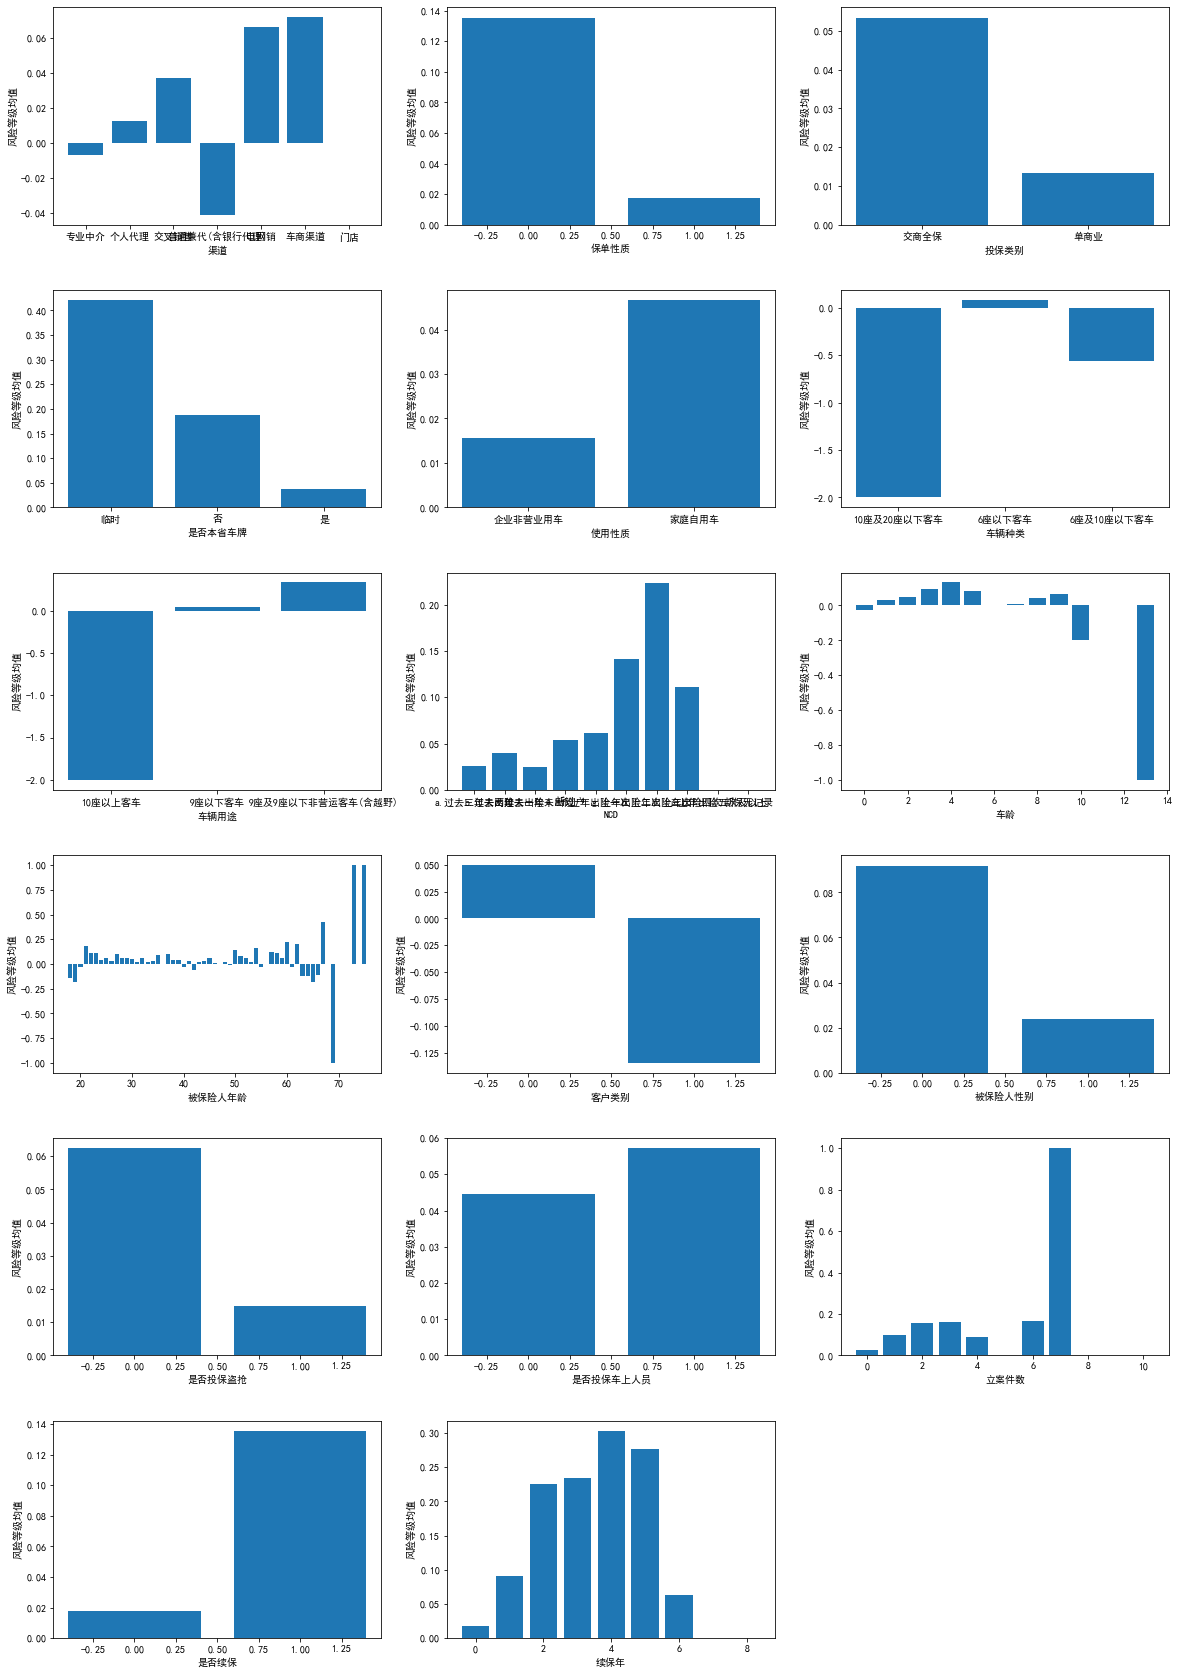

In [10]:
#绘制分类变量与风险等级的柱状图
number = 1
plt.figure(figsize=(20,30))
plt.subplots_adjust(hspace=0.3, wspace=0.2)

for i in [ '渠道', '保单性质', '投保类别', '是否本省车牌', '使用性质', '车辆种类', '车辆用途', 'NCD','车龄','被保险人年龄',
       '客户类别', '被保险人性别', '是否投保盗抢','是否投保车上人员', '立案件数', '是否续保','续保年',]:
    plt.subplot(6, 3, number)
    plt.bar(data_train.groupby(i).mean()['风险类别（A最低，E最高）'].index,data_train.groupby(i).mean()['风险类别（A最低，E最高）'])
    plt.xlabel(str(i))
    plt.ylabel('风险等级均值')
    number += 1

### 取两个类别作为典型分析：渠道虽然图形差异较大，但是不同渠道分线等级绝对值相差不大，因此不作为标签。是否本省车牌不仅图像上相差显著，数值上差距也较大，因此选择为标签，同理其他变量也用相同分析方法，最终确定如下几个标签：
#### 是否本省车牌：是，否，零时
#### 车辆种类：10座以下客车，10座以上客车
#### 车辆用途：9座以下客车，9座一下非客车，10座以上客车
#### 客户类别：个人，企业
#### 立案件数：低（5次及5次以下），高（5次以上）
#### 车龄：低（10年以下），高（10年及10年以上）
#### 年龄：青年（23及23岁以下），中年（23到50岁之间），老年（50及50岁以上）

## 分析连续变量

In [11]:
import warnings
 
warnings.filterwarnings('ignore')

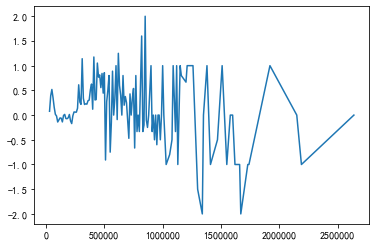

In [12]:
# 计算车辆购置价以万取整，然后绘制折线图
data_train.loc[data_train.index ,'新车购置价2'] = (data_train['新车购置价']//10000+1)*10000
plt.plot(data_train.groupby('新车购置价2').mean()['风险类别（A最低，E最高）'])

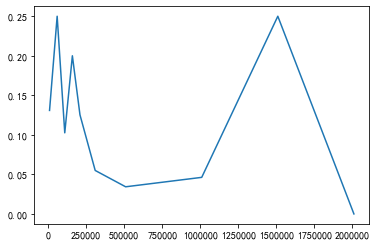

In [13]:
# 计算三者险保额万取整，然后绘制折线图
data_train.loc[:,'三者险保额2'] = (data_train['三者险保额']//10000+1)*10000
plt.plot(data_train.groupby('三者险保额2').mean()['风险类别（A最低，E最高）'])

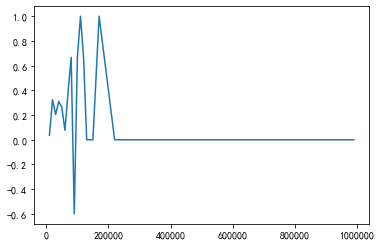

In [14]:
# 计算已决赔款万取整，然后绘制折线图
data_train.loc[:,'已决赔款2'] = (data_train['已决赔款']//10000+1)*10000
plt.plot(data_train.groupby('已决赔款2').mean()['风险类别（A最低，E最高）'])


### 观察上图发现图像没有明显趋势，认为新车购置价,三者险保额,已决赔款对风险等级没有影响

In [15]:
data_train.columns

Index(['保单号', '起保日期', '终止日期', '渠道', '品牌', '车系', '保单性质', '续保年', '投保类别',
       '是否本省车牌', '使用性质', '车辆种类', '车辆用途', '新车购置价', '车龄', '险种', 'NCD',
       '风险类别（A最低，E最高）', '客户类别', '被保险人性别', '被保险人年龄', '是否投保车损', '是否投保盗抢',
       '是否投保车上人员', '三者险保额', '签单保费', '立案件数', '已决赔款', '是否续保', 'is_risk',
       '新车购置价2', '三者险保额2', '已决赔款2'],
      dtype='object')

In [16]:
X_columns = [ '车辆种类', '车辆用途', '客户类别', '立案件数', '车龄', '被保险人年龄']
X = data_train[X_columns]

License_plate = pd.get_dummies(X['车辆种类'], prefix='车辆种类' )

risk = pd.get_dummies(X['车辆用途'], prefix='车辆用途' )

use = pd.get_dummies(X['客户类别'], prefix='客户类别' )

NCD = pd.get_dummies(X['立案件数'], prefix='立案件数' )

for var in [ '车辆种类', '车辆用途', '客户类别', '立案件数']:
    del X[var]
X = pd.concat([X, License_plate, risk,use, NCD], axis=1)

In [17]:
License_plate = pd.get_dummies(data_test['车辆种类'], prefix='车辆种类' )

risk = pd.get_dummies(data_test['车辆用途'], prefix='车辆用途' )

use = pd.get_dummies(data_test['客户类别'], prefix='客户类别' )

NCD = pd.get_dummies(data_test['立案件数'], prefix='立案件数' )

for var in [ '车辆种类', '车辆用途', '客户类别', '立案件数']:
    del data_test[var]
data_test = pd.concat([data_test, License_plate, risk,use, NCD], axis=1)

In [18]:
from sklearn.model_selection import train_test_split
 
y = data_train['风险类别（A最低，E最高）']
train_X,test_X,train_y,test_y=train_test_split(X,y,train_size=0.6)

In [19]:
from sklearn.linear_model import LogisticRegression
modelLR=LogisticRegression()
modelLR.fit(train_X,train_y)
modelLR.score(test_X,test_y)

0.7281427412814274

In [20]:
data_test['立案件数_8']= 0
data_test['立案件数_10']= 0

In [21]:
data_test['风险类别（A最低，E最高）'] = modelLR.predict(data_test[X.columns])

In [22]:
model_data = data.copy()
model_data.drop(columns = ['保单号', '起保日期', '终止日期', '渠道', '品牌', '车系','使用性质', '投保类别'],inplace = True)

In [23]:
License_plate = pd.get_dummies(model_data['车辆种类'], prefix='车辆种类' )

risk = pd.get_dummies(model_data['车辆用途'], prefix='车辆用途' )

use = pd.get_dummies(model_data['客户类别'], prefix='客户类别' )

NCD = pd.get_dummies(model_data['立案件数'], prefix='立案件数' )

for var in [ '车辆种类', '车辆用途', '客户类别', '立案件数']:
    del model_data[var]
data_test = pd.concat([model_data, License_plate, risk,use, NCD], axis=1)

In [24]:
model_data.loc[data_test.index,'风险类别（A最低，E最高）'] = data_test

In [25]:
License_plate = pd.get_dummies(model_data['是否本省车牌'], prefix='是否本省车牌' )
NCD = pd.get_dummies(model_data['NCD'], prefix='NCD' )

for var in ['是否本省车牌','NCD']:
    del model_data[var]
model_data = pd.concat([model_data, License_plate,use, NCD], axis=1)

In [26]:
model_data

,保单性质,续保年,新车购置价,车龄,险种,风险类别（A最低，E最高）,被保险人性别,被保险人年龄,是否投保车损,是否投保盗抢,...,NCD_a.过去三年未出险,NCD_b.过去两年未出险,NCD_c.过去一年未出险,NCD_e.新过户,NCD_f.上年出险一次,NCD_g.上年出险二次,NCD_h.上年出险三次,NCD_i.上年出险四次,NCD_j.上年出险五次及以上,NCD_新保无记录
0,1,0,100900,1,0,0,0,27.0,1,0,...,0,0,1,0,0,0,0,0,0,0
1,1,0,191800,1,1,0,0,36.0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,200800,2,1,0,0,46.0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,0,56900,4,0,0,1,28.0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,1,0,81600,14,1,0,1,49.0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65530,1,0,37800,9,1,0,1,44.0,0,0,...,0,0,0,0,0,0,0,0,0,0
65531,1,0,235800,4,0,0,0,38.0,1,0,...,0,1,0,0,0,0,0,0,0,0
65532,1,0,225900,7,1,0,0,29.0,0,0,...,0,0,0,0,0,0,0,0,0,0
65533,1,0,211800,7,0,0,0,37.0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [27]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


X_columns = model_data.columns[model_data.columns!='是否续保']
X = model_data[X_columns]

scaler = StandardScaler().fit(X)
y = model_data['是否续保']
train_X,test_X,train_y,test_y=train_test_split(X,y,train_size=0.6)
train_X = pd.DataFrame(scaler.transform(train_X))
test_X = pd.DataFrame(scaler.transform(test_X))

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
param_test1 = {'n_estimators':[56],
               'max_depth':[17],
               'min_samples_split':[110,115],
               'min_samples_leaf':[9],
               'max_features':[14]}

gsearch1 = GridSearchCV(estimator = RandomForestClassifier(max_features='sqrt' ,random_state=10), 
                       param_grid = param_test1, scoring='roc_auc',cv=3)
gsearch1.fit(train_X,train_y)
print( gsearch1.best_params_, gsearch1.best_score_)#,gsearch1.cv_results_打印拟合结果)

{'max_depth': 17, 'max_features': 14, 'min_samples_leaf': 9, 'min_samples_split': 115, 'n_estimators': 56} 0.9989556894414995


In [92]:
predict_y = gsearch1.predict_proba(X[X['风险类别（A最低，E最高）']<0])

In [95]:
predict_y[:,1].mean()

0.10780111969836208

In [47]:
X['签单保费'] = X['签单保费']*0.9
predict_y = gsearch1.predict_proba(X)
predict_y[:,1].mean()

0.11320367861435425

In [87]:
X['签单保费'] = X['签单保费']*0.9
predict_y = gsearch1.predict_proba(X)
predict_y[:,1].mean()

0.11344886854777549

In [97]:
0.10780111969836208 - 0.11344886854777549

-0.005647748849413409